In [1]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.curandom
import pycuda.gpuarray as gpuarray

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

/n/home01/bcook/.conda/envs/my_home/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import instrument as ins
import isochrones as iso
import galaxy as gal
import driver 

GPU acceleration enabled


In [4]:
import gpu_utils

In [5]:
generator = pycuda.curandom.XORWOWRandomNumberGenerator()

In [9]:
generator.block_count

14

In [10]:
generator.generators_per_block

1024

In [26]:
np.random.seed(0)
np.random.poisson(lam=5., size=100)

array([ 9,  5,  6,  5,  5,  8,  4,  5,  4,  3,  3,  7,  3,  3,  4,  5,  2,
        1,  7,  7, 10,  5,  8,  8,  6,  4,  4,  3,  1,  5,  6,  5,  5,  4,
        1,  7,  2,  7,  6,  2,  6,  5,  7,  5,  4,  5, 10,  6,  4,  7,  3,
        2,  2,  6,  2,  5,  3,  6,  2,  4,  4,  4,  8,  7, 11,  3,  4,  1,
        4,  5,  1,  2,  2,  5,  5,  5,  7,  8,  4,  6,  4, 10,  3,  8,  5,
        7,  3,  8,  2,  1,  4,  4,  4,  4,  6,  4, 12,  1,  6,  3])

In [27]:
def seed_getter_fixed(N):
    result = pycuda.gpuarray.empty([N], np.int32)
    np.random.seed(0)
    value = np.random.randint(0, 2**31 - 1)
    return result.fill(value)

In [33]:
pycuda.curandom.seed_getter_uniform(100)

array([1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036834,
       1482036834, 1482036834, 1482036834, 1482036834, 1482036

In [34]:
seed_getter_fixed(100)

array([209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 209652396, 209652396,
       209652396, 209652396, 209652396, 209652396, 

In [31]:
code_simple = """
   #include <curand_kernel.h>

   extern "C"
   {
   __global__ void my_poisson(curandState *global_state, const float *exp_nums, const int N, const int num_lams, int *output)
   {
      /* Initialize variables */
      int idx = blockIdx.x*blockDim.x + threadIdx.x;
      int idy = blockIdx.y*blockDim.y + threadIdx.y;

      int id_result = (num_lams * idx) + idy;

      curandState local_state = global_state[idy];

      if ((idx < N) && (idy < num_lams)) {
          output[id_result] = curand_poisson(&local_state, exp_nums[idy]);
      }

      /* Save back state */
      global_state[idy] = local_state;
   }

   }
"""

In [34]:
mod = SourceModule(code_simple, keep=False, no_extern_c=True)

my_poiss = mod.get_function('my_poisson')

def poiss_gpu(lam_arr, N):
    N_bins = len(lam_arr)
    generator = pycuda.curandom.XORWOWRandomNumberGenerator()
    result = np.zeros((N, N_bins), dtype=np.int32)
    
    d_block = 32
    
    block_dim = (d_block, d_block,1)
    grid_dim = (N/d_block + 1, N_bins/d_block + 1)
    print(grid_dim)
    my_poiss(generator.state, cuda.In(lam_arr), np.int32(N), np.int32(N_bins), cuda.Out(result), block=block_dim, grid=grid_dim)
    return result

In [35]:
lam = np.arange(400).astype(np.float32)
N = 10000
N_bins = len(lam)

In [15]:
%%time
rand_cpu = np.random.poisson(lam, size=(N, N_bins))

KeyboardInterrupt: 

In [17]:
rng = pycuda.curandom.XORWOWRandomNumberGenerator()

In [18]:
%%time
results = np.zeros((N, N_bins))
for l,i in enumerate(lam):
    results[:,i] = rng.gen_poisson(N, np.uint32, l).get()

/n/home01/bcook/.conda/envs/my_home/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


CPU times: user 9.35 s, sys: 2.11 s, total: 11.5 s
Wall time: 11.5 s


In [19]:
%%time
rand_gpu = poiss_gpu(lam, N)

(31251, 13)
CPU times: user 1.01 s, sys: 4.85 s, total: 5.86 s
Wall time: 10 s


In [18]:
rand_cpu.shape

(10000, 40)

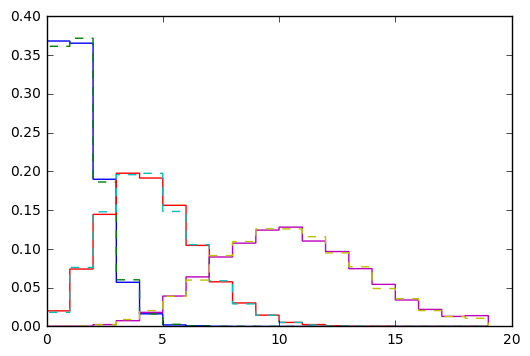

In [208]:
fig, axis = plt.subplots()
for i in np.arange(3):
    axis.hist(rand_cpu[:,i], normed=True, histtype='step', bins=np.arange(20), ls='-')
    axis.hist(rand_gpu[:,i], normed=True, histtype='step', bins=np.arange(20), ls='--')

In [4]:
filters = [ins.Filter.HST_F475W(1.), ins.Filter.HST_F814W(1.)]

In [5]:
iso_model = iso.Isochrone_Model(filters)

In [6]:
imf, mags = iso_model.get_isochrone(10., 0.)

In [179]:
fluxes = np.array([filters[i].mag_to_counts(mags[i]) for i in range(2)])

Npix = 0.5
lams = (imf*Npix).astype(np.float32)
fluxes = fluxes.astype(np.float32)#(10.**np.random.uniform(-1, 0, (2, 100))).astype(np.float32)

In [378]:
lams = np.ones(100).astype(np.float32)
fluxes = np.ones((2,100)).astype(np.float32)#(10.**np.random.uniform(-1, 0, (2, 100))).astype(np.float32)

In [424]:
code_complex = """
   #include <curand_kernel.h>

   extern "C"
   {
   __global__ void poisson_sum(curandState *global_state, const float *exp_nums, const float *fluxes, const int num_bands, const int num_bins, const int N, float *pixels)
   {
      /* Initialize variables */
      int id_imx = blockIdx.x*blockDim.x + threadIdx.x;
      int id_imy = blockIdx.y*blockDim.y + threadIdx.y;
      int id_pix = (id_imx) + N*id_imy;
      int id_within_block = threadIdx.y + (blockDim.x * threadIdx.x);
      int block_id = blockIdx.x*gridDim.x + blockIdx.y;

      curandState local_state = global_state[id_within_block];
      float results[10] = {0.0};

      float flux;
      int count, skip;


      if ((id_imx < N) && (id_imy < N)) {
          /* Update local_state, to make sure values are very random */
          skip = 128 + block_id;
          skipahead(skip, &local_state);
          for (int i = 0; i < num_bins; i++){
             count = curand_poisson(&local_state, exp_nums[i]);
             for (int f = 0; f < num_bands; f++){
                flux = fluxes[i + (f*num_bins)];
                results[f] += count * flux;
             }
          }
          /* Save results for each band */
          for (int f = 0; f < num_bands; f++){
             pixels[id_pix + (N*N)*f] = results[f];
          }
      }

      /* Save back state */
      global_state[id_within_block] = local_state;
   }

   }
"""

mod_2 = SourceModule(code_complex, keep=False, no_extern_c=True)

poiss_sum = mod_2.get_function('poisson_sum')

def poiss_sum_gpu(expected_nums, fluxes, N_scale):
    N_bins = len(expected_nums)
    N_bands = fluxes.shape[0]
    assert(N_bins == fluxes.shape[1])
    generator = pycuda.curandom.XORWOWRandomNumberGenerator(seed_getter=pycuda.curandom.seed_getter_unique)
    result = np.zeros((N_bands, N_scale, N_scale), dtype=np.float32)
    
    d_block = 32
    
    block_dim = (d_block, d_block,1)
    grid_dim = (N_scale/d_block + 1, N_scale/d_block + 1)
    poiss_sum(generator.state, cuda.In(expected_nums), cuda.In(fluxes), np.int32(N_bands), np.int32(N_bins), np.int32(N_scale), cuda.Out(result), block=block_dim, grid=grid_dim)
    return result

In [426]:
%%time
N_scale = 512
a_small = poiss_sum_gpu(lams, fluxes, N_scale)

CPU times: user 69 ms, sys: 108 ms, total: 177 ms
Wall time: 369 ms


In [432]:
%%time
N_scale = 4096
a_large = poiss_sum_gpu(lams, fluxes, N_scale)

CPU times: user 1.97 s, sys: 823 ms, total: 2.79 s
Wall time: 3.04 s


In [433]:
%%time
filters[0].psf_convolve(a_large[0], simple=False)
filters[1].psf_convolve(a_large[1], simple=False)

CPU times: user 6.35 s, sys: 3.9 s, total: 10.3 s
Wall time: 10.4 s


In [416]:
b = np.random.normal(loc=np.mean(a_large[0]), scale=np.std(a_large[0]), size=a_large[0].shape)

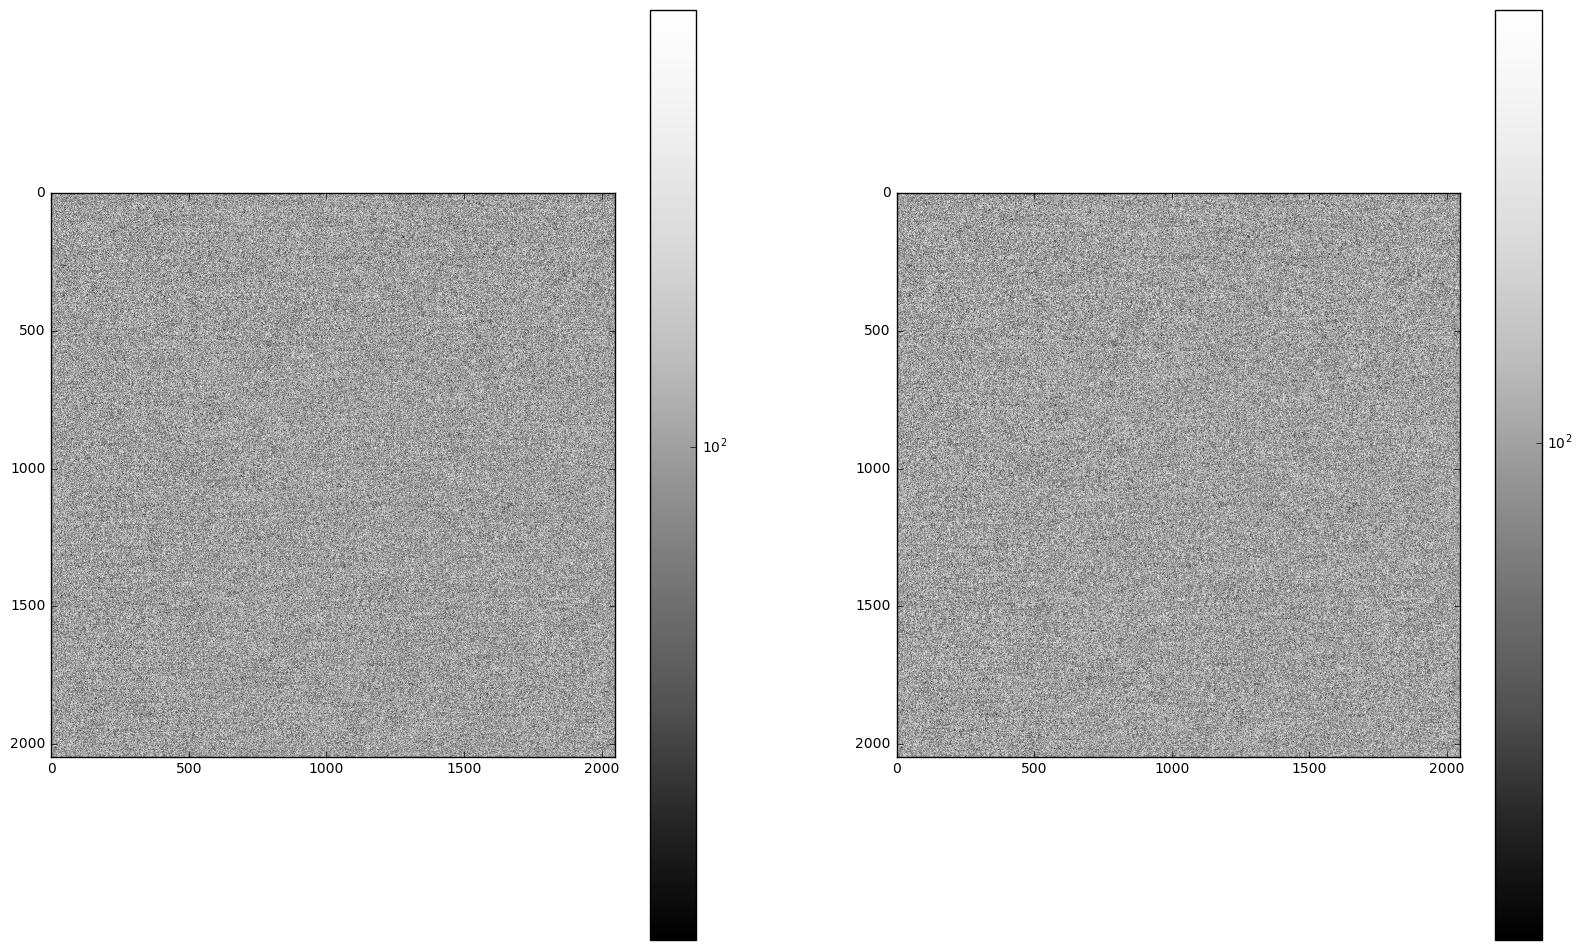

In [392]:
fig,axes = plt.subplots(figsize=(20, 12), ncols=2)
plt.subplot(axes[0])
plt.imshow(filters[0].psf_convolve(a_large[0], simple=False), cmap='Greys_r', interpolation=None, norm=mpl.colors.LogNorm())
# plt.imshow(a[0], cmap='viridis_r', interpolation='None', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.subplot(axes[1])
# plt.imshow(b, cmap='viridis_r', interpolation='None', norm=mpl.colors.LogNorm())
plt.imshow(filters[1].psf_convolve(a_large[1], simple=False), cmap='Greys_r', interpolation=None, norm=mpl.colors.LogNorm())
# plt.imshow(a[1], cmap='viridis_r', interpolation='None', norm=mpl.colors.LogNorm())
plt.colorbar();

In [428]:
a_f_small = np.fft.fft2(a_small[0])
a_2_small = np.fft.ifft2(a_f_small * np.conjugate(a_f_small)).real
b_f = np.fft.fft2(b)
b_2 = np.fft.ifft2(b_f * np.conjugate(b_f)).real

a_f_large = np.fft.fft2(a_large[0])
a_2_large = np.fft.ifft2(a_f_large * np.conjugate(a_f_large)).real

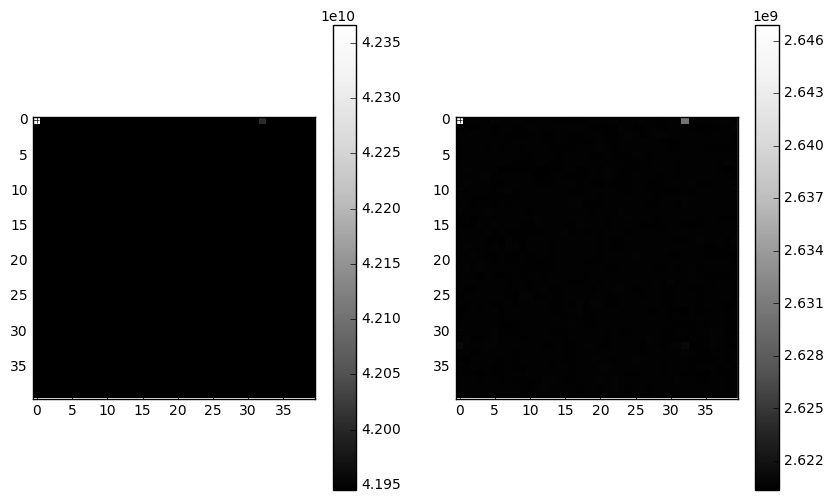

In [430]:
fig,axes = plt.subplots(figsize=(10, 6), ncols=2)
plt.subplot(axes[0])
# plt.imshow(filters[0].psf_convolve(a[0], simple=False), cmap='viridis_r', interpolation=None, norm=mpl.colors.LogNorm())
plt.imshow(a_2_large[:40,:40], cmap='Greys_r', interpolation='None')
plt.colorbar()
plt.subplot(axes[1])
plt.imshow(a_2_small[:40,:40], cmap='Greys_r', interpolation='None')
# plt.imshow(filters[1].psf_convolve(a[1], simple=False), cmap='viridis_r', interpolation=None, norm=mpl.colors.LogNorm())
# plt.imshow(a[1], cmap='viridis_r', interpolation='None', norm=mpl.colors.LogNorm())
plt.colorbar()

In [291]:
i = np.arange(a_2.shape[0])

X = np.tile(i, a_2.shape[1]).reshape(a_2.shape)
Y = X.T

R = np.sqrt(X**2 + Y**2).flatten()

In [292]:
R_argsort = R.argsort()

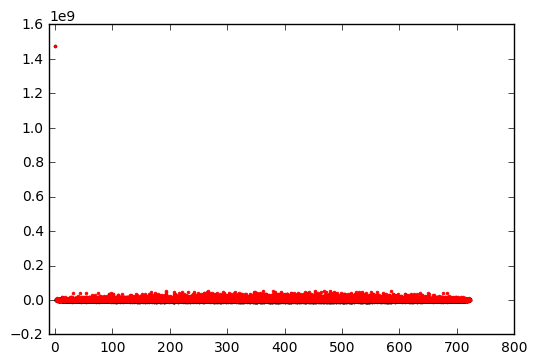

In [293]:
plt.plot(R[R_argsort], b_2.flatten()[R_argsort], 'k.', ms=4)
plt.plot(R[R_argsort], a_2.flatten()[R_argsort], 'r.', ms=4)
plt.xlim(xmin=-10);

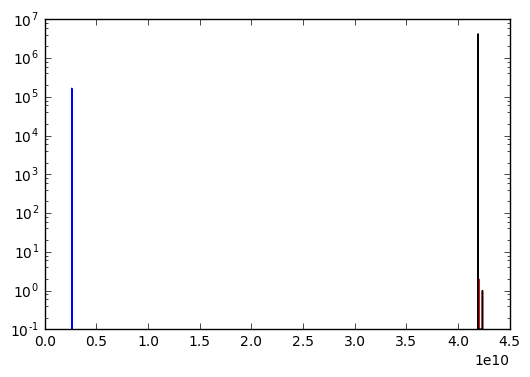

In [431]:
plt.hist(a_2_large.flatten(), histtype='step', log=True, color='r', bins=100);
plt.hist(a_2_small.flatten(), histtype='step', log=True, color='b', bins=100);
plt.hist(b_2.flatten(), histtype='step', log=True, color='k', bins=100);